Otsu's threshold value: 87
Number of labeled feature is 9
[INFO] 9 unique segments found


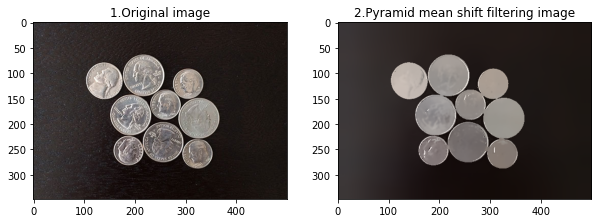

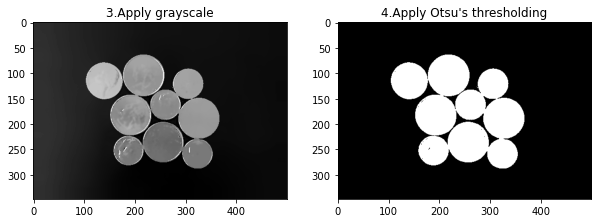

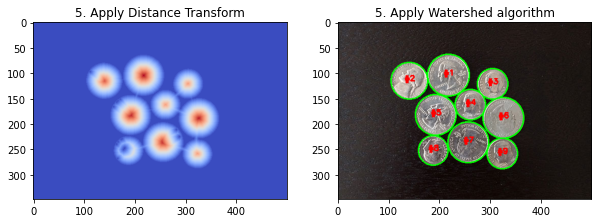

In [1]:
#$ pip install --upgrade scipy
#$ pip install --upgrade scikit-image
from skimage.feature import peak_local_max
from skimage.segmentation import watershed
from scipy import ndimage
import cv2
import mahotas
import numpy as np
from matplotlib import pyplot as plt

#Open source image
path = r'../images/watershed.jpg'
original = cv2.imread(path)
original = cv2.cvtColor(original, cv2.COLOR_BGR2RGB)
shifted = cv2.pyrMeanShiftFiltering(original, 20, 55)

fig1 = plt.figure(figsize=(10, 7))
ax1 = fig1.add_subplot(1,2,1)
ax1.set_title('1.Original image')
ax1.imshow(original)
ax2 = fig1.add_subplot(1,2,2)
ax2.set_title('2.Pyramid mean shift filtering image')
ax2.imshow(shifted)

#Apply Otsu Thresholding
bw = cv2.cvtColor(shifted, cv2.COLOR_RGB2GRAY)
fig2 = plt.figure(figsize=(10, 7))
ax1 = fig2.add_subplot(1,2,1)
ax1.set_title('3.Apply grayscale')
ax1.imshow(bw, cmap='gray')

T = mahotas.thresholding.otsu(bw)
print("Otsu's threshold value: {}".format(T))
bw[bw > T] = 255
bw[bw < 255] = 0

ax2 = fig2.add_subplot(1,2,2)
ax2.set_title("4.Apply Otsu's thresholding")
ax2.imshow(bw, cmap='gray')

#Perform Distance Transform
dist = cv2.distanceTransform(bw, cv2.DIST_L2, 3)
#ist2 = ndimage.distance_transform_edt(bw) #must from scipy import ndimage first
#cv2.normalize(dist, dist, 0, 1.0, cv2.NORM_MINMAX)
localMax = peak_local_max(dist, indices=False, min_distance=20,labels=bw)

fig3 = plt.figure(figsize=(10,7))
ax1 = fig3.add_subplot(1,2,1)
ax1.set_title('5. Apply Distance Transform')
ax1.imshow(dist, cmap='coolwarm')

# perform a connected component analysis on the local peaks, using 8-connectivity, then apply the Watershed algorithm
markers, num_features = ndimage.label(localMax, structure=np.ones((3, 3)))
labels = watershed(-dist, markers, mask=bw)
print('Number of labeled feature is {}'.format(num_features))
print("[INFO] {} unique segments found".format(len(np.unique(labels)) - 1))

# loop over the unique labels returned by the Watershed algorithm
for label in np.unique(labels):
	# if the label is zero, we are examining the 'background' so simply ignore it
	if label == 0:
		continue
	# otherwise, allocate memory for the label region and draw it on the mask
	mask = np.zeros(bw.shape, dtype="uint8")
	mask[labels == label] = 255
	# detect contours in the mask and grab the largest one
	(cnts, _) = cv2.findContours(mask.copy(), cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
	c = max(cnts, key=cv2.contourArea)
	# draw a circle enclosing the object
	((x, y), r) = cv2.minEnclosingCircle(c)
	cv2.circle(original, (int(x), int(y)), int(r), (0, 255, 0), 2)
	cv2.putText(original, "#{}".format(label), (int(x) - 10, int(y)), cv2.FONT_HERSHEY_SIMPLEX, 0.5, (255, 0, 0), 2)

# show the output image
ax2 = fig3.add_subplot(1,2,2)
ax2.set_title('5. Apply Watershed algorithm')
ax2.imshow(original)